# Integrated Multi-Dataset Deepfake Detection Training

## Overview
This notebook implements **integrated training** across multiple deepfake detection datasets using the **Complete Attention Model**.

### Datasets Integrated:
1. **FaceForensics++**: Multiple manipulation methods (Deepfakes, Face2Face, FaceSwap, etc.)
2. **Celeb-DF**: Celebrity deepfake dataset with high-quality fakes
3. **Deepfake Detection Challenge (DFDC)**: Kaggle competition dataset
4. **HiDF**: High-fidelity deepfake dataset (videos and images)

### Key Features:
- Configurable data percentage (default: 5%)
- Complete Attention Model architecture
- Multi-domain feature extraction (Spatial, Frequency, Semantic)
- Cross-dataset performance analysis

---

## Section 1: Setup & Configuration

In [1]:
# ============================================================================
# IMPORTS
# ============================================================================

import os
import json
import numpy as np
import pandas as pd
import random
from pathlib import Path
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Image processing
import cv2
from PIL import Image

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision.transforms as transforms

# Models
import timm
from facenet_pytorch import MTCNN

# Analysis and visualization
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score
)

# Set random seeds for reproducibility
def set_seed(seed=42):
    """Set random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"{'='*70}")
print("ENVIRONMENT SETUP")
print(f"{'='*70}")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
else:
    print("⚠ Running on CPU - training will be slower")
print(f"PyTorch Version: {torch.__version__}")
print(f"{'='*70}")

ENVIRONMENT SETUP
Using device: cuda
GPU: NVIDIA GeForce RTX 3060 Laptop GPU
CUDA Version: 11.8
GPU Memory: 6.00 GB
PyTorch Version: 2.7.1+cu118


In [49]:
# ============================================================================
# CONFIGURATION
# ============================================================================

class Config:
    """Central configuration for the integrated training pipeline."""
    
    # ==========================================================================
    # DATA PERCENTAGE - Controls how much data to use from each dataset
    # ==========================================================================
    DATA_PERCENTAGE = 0.03  # 3% of each dataset (adjustable: 0.01 to 1.0)
    
    # ==========================================================================
    # Dataset Paths
    # ==========================================================================
    BASE_DIR = Path('E:/MMF Deepfake Detection')
    DATASETS_DIR = BASE_DIR / 'datasets'
    
    # Individual dataset paths
    FFPP_DIR = DATASETS_DIR / 'FaceForensics++'
    CELEBDF_DIR = DATASETS_DIR / 'CelebDF'
    DFDC_DIR = DATASETS_DIR / 'deepfake-detection-challenge'
    HIDF_DIR = DATASETS_DIR / 'HiDF'
    
    # Output directories
    PREPROCESSED_DIR = BASE_DIR / 'preprocessed_faces_integrated'
    FEATURES_DIR = BASE_DIR / 'extracted_features_integrated'
    CHECKPOINTS_DIR = BASE_DIR / 'checkpoints'
    RESULTS_DIR = BASE_DIR / 'results'
    INTEGRATED_METADATA_PATH = BASE_DIR / 'integrated_metadata.csv'
    
    # Data settings
    FRAMES_PER_VIDEO = 20
    FACE_SIZE = 299
    TRAIN_RATIO = 0.8
    
    # Feature dimensions
    SPATIAL_DIM = 2048   # Xception output
    FREQ_DIM = 4         # FFT statistical features
    SEMANTIC_DIM = 768   # DINOv2 ViT-B/14 output
    
    # Training settings
    BATCH_SIZE = 64
    LEARNING_RATE = 1e-4
    EPOCHS = 20
    HIDDEN_DIM1 = 512
    HIDDEN_DIM2 = 256
    DROPOUT = 0.5
    FUSION_DIM = 512
    
    # Early stopping
    PATIENCE = 5
    MIN_DELTA = 0.001

config = Config()

# Create directory structure
def create_directories():
    """Create all necessary directories."""
    dirs = [
        config.PREPROCESSED_DIR / 'real',
        config.PREPROCESSED_DIR / 'fake',
        config.FEATURES_DIR / 'spatial',
        config.FEATURES_DIR / 'frequency',
        config.FEATURES_DIR / 'semantic',
        config.CHECKPOINTS_DIR,
        config.RESULTS_DIR
    ]
    for dir_path in dirs:
        dir_path.mkdir(parents=True, exist_ok=True)
    print("✓ Directory structure created")

create_directories()

# Display configuration
print(f"\n{'='*70}")
print("PROJECT CONFIGURATION")
print(f"{'='*70}")
print(f"Data Percentage: {config.DATA_PERCENTAGE * 100:.1f}%")
print(f"Base Directory: {config.BASE_DIR.absolute()}")
print(f"Frames per video: {config.FRAMES_PER_VIDEO}")
print(f"Batch size: {config.BATCH_SIZE}")
print(f"Learning rate: {config.LEARNING_RATE}")
print(f"Epochs: {config.EPOCHS}")
print(f"Feature dimensions: Spatial={config.SPATIAL_DIM}, Freq={config.FREQ_DIM}, Semantic={config.SEMANTIC_DIM}")
print(f"{'='*70}")

✓ Directory structure created

PROJECT CONFIGURATION
Data Percentage: 3.0%
Base Directory: E:\MMF Deepfake Detection
Frames per video: 20
Batch size: 64
Learning rate: 0.0001
Epochs: 20
Feature dimensions: Spatial=2048, Freq=4, Semantic=768


## Section 2: Dataset Loaders

Load and parse metadata from all four datasets.

In [50]:
# ============================================================================
# FACEFORENSICS++ DATASET LOADER
# ============================================================================

def load_ffpp_dataset(data_percentage=None):
    """
    Load FaceForensics++ dataset metadata.
    Uses CSV files from datasets/FaceForensics++/csv/
    
    Returns:
        DataFrame with columns: video_id, label, path, manipulation, dataset
    """
    data_percentage = data_percentage or config.DATA_PERCENTAGE
    csv_dir = config.FFPP_DIR / 'csv'
    
    if not csv_dir.exists():
        print(f"⚠ FaceForensics++ CSV directory not found: {csv_dir}")
        return pd.DataFrame()
    
    data = []
    
    # Load original (real) videos
    original_csv = csv_dir / 'original.csv'
    if original_csv.exists():
        df_orig = pd.read_csv(original_csv)
        # Sample the required percentage
        n_samples = max(1, int(len(df_orig) * data_percentage))
        df_orig_sampled = df_orig.sample(n=n_samples, random_state=42)
        
        for _, row in df_orig_sampled.iterrows():
            file_path = row['File Path']
            video_name = Path(file_path).stem
            full_path = config.FFPP_DIR / file_path
            if full_path.exists():
                data.append({
                    'video_id': f'FFPP_original_{video_name}',
                    'label': 'real',
                    'path': str(full_path),
                    'manipulation': 'Original',
                    'dataset': 'FaceForensics++'
                })
    
    # Load fake videos from different manipulation methods
    manipulation_csvs = ['Deepfakes.csv', 'Face2Face.csv', 'FaceSwap.csv', 
                         'NeuralTextures.csv', 'FaceShifter.csv']
    
    for csv_name in manipulation_csvs:
        csv_path = csv_dir / csv_name
        if csv_path.exists():
            df = pd.read_csv(csv_path)
            manipulation = csv_name.replace('.csv', '')
            
            # Sample the required percentage
            n_samples = max(1, int(len(df) * data_percentage))
            df_sampled = df.sample(n=n_samples, random_state=42)
            
            for _, row in df_sampled.iterrows():
                file_path = row['File Path']
                video_name = Path(file_path).stem
                full_path = config.FFPP_DIR / file_path
                if full_path.exists():
                    data.append({
                        'video_id': f'FFPP_{manipulation}_{video_name}',
                        'label': 'fake',
                        'path': str(full_path),
                        'manipulation': manipulation,
                        'dataset': 'FaceForensics++'
                    })
    
    # Also check FF++_Metadata.csv for DeepFakeDetection videos
    metadata_csv = csv_dir / 'FF++_Metadata.csv'
    if metadata_csv.exists():
        df_meta = pd.read_csv(metadata_csv)
        # Filter for DeepFakeDetection
        df_dfd = df_meta[df_meta['File Path'].str.contains('DeepFakeDetection', na=False)]
        
        n_samples = max(1, int(len(df_dfd) * data_percentage))
        df_dfd_sampled = df_dfd.sample(n=min(n_samples, len(df_dfd)), random_state=42)
        
        for _, row in df_dfd_sampled.iterrows():
            file_path = row['File Path']
            video_name = Path(file_path).stem
            full_path = config.FFPP_DIR / file_path
            label = 'fake' if row['Label'] == 'FAKE' else 'real'
            if full_path.exists():
                data.append({
                    'video_id': f'FFPP_DeepFakeDetection_{video_name}',
                    'label': label,
                    'path': str(full_path),
                    'manipulation': 'DeepFakeDetection',
                    'dataset': 'FaceForensics++'
                })
    
    df_result = pd.DataFrame(data)
    print(f"✓ FaceForensics++: Loaded {len(df_result)} videos ({data_percentage*100:.1f}%)")
    if len(df_result) > 0:
        print(f"  Real: {len(df_result[df_result['label'] == 'real'])}, Fake: {len(df_result[df_result['label'] == 'fake'])}")
    
    return df_result

In [51]:
# ============================================================================
# CELEB-DF DATASET LOADER
# ============================================================================

def load_celebdf_dataset(data_percentage=None):
    """
    Load Celeb-DF dataset metadata.
    Uses List_of_testing_videos.txt for ground truth labels.
    
    Format: <label> <path>
    - Label 1 = Real
    - Label 0 = Fake (Celeb-synthesis)
    
    Returns:
        DataFrame with columns: video_id, label, path, manipulation, dataset
    """
    data_percentage = data_percentage or config.DATA_PERCENTAGE
    list_file = config.CELEBDF_DIR / 'List_of_testing_videos.txt'
    
    if not list_file.exists():
        print(f"⚠ Celeb-DF list file not found: {list_file}")
        return pd.DataFrame()
    
    data = []
    
    with open(list_file, 'r') as f:
        lines = f.readlines()
    
    # Parse all entries
    all_entries = []
    for line in lines:
        line = line.strip()
        if not line:
            continue
        parts = line.split()
        if len(parts) >= 2:
            file_label = int(parts[0])
            file_path = parts[1]
            all_entries.append((file_label, file_path))
    
    # Sample the required percentage
    n_samples = max(1, int(len(all_entries) * data_percentage))
    random.seed(42)
    sampled_entries = random.sample(all_entries, min(n_samples, len(all_entries)))
    
    for file_label, file_path in sampled_entries:
        video_name = Path(file_path).stem
        folder_name = Path(file_path).parent.name
        full_path = config.CELEBDF_DIR / file_path
        
        # Label 1 = Real, Label 0 = Fake
        label = 'real' if file_label == 1 else 'fake'
        
        # Determine manipulation type based on folder
        if 'synthesis' in folder_name.lower():
            manipulation = 'Celeb-synthesis'
        elif 'real' in folder_name.lower():
            manipulation = 'Original'
        else:
            manipulation = folder_name
        
        if full_path.exists():
            data.append({
                'video_id': f'CelebDF_{folder_name}_{video_name}',
                'label': label,
                'path': str(full_path),
                'manipulation': manipulation,
                'dataset': 'Celeb-DF'
            })
    
    df_result = pd.DataFrame(data)
    print(f"✓ Celeb-DF: Loaded {len(df_result)} videos ({data_percentage*100:.1f}%)")
    if len(df_result) > 0:
        print(f"  Real: {len(df_result[df_result['label'] == 'real'])}, Fake: {len(df_result[df_result['label'] == 'fake'])}")
    
    return df_result

In [52]:
# ============================================================================
# DFDC (DEEPFAKE DETECTION CHALLENGE) DATASET LOADER
# ============================================================================

def load_dfdc_dataset(data_percentage=None):
    """
    Load DFDC dataset metadata.
    Uses metadata.json from train_sample_videos directory.
    
    Format: {"filename.mp4": {"label": "REAL"/"FAKE", "split": "train", "original": ...}}
    
    Returns:
        DataFrame with columns: video_id, label, path, manipulation, dataset
    """
    data_percentage = data_percentage or config.DATA_PERCENTAGE
    videos_dir = config.DFDC_DIR / 'train_sample_videos'
    metadata_file = videos_dir / 'metadata.json'
    
    if not metadata_file.exists():
        print(f"⚠ DFDC metadata file not found: {metadata_file}")
        return pd.DataFrame()
    
    data = []
    
    with open(metadata_file, 'r') as f:
        metadata = json.load(f)
    
    # Get all entries
    all_entries = list(metadata.items())
    
    # Sample the required percentage
    n_samples = max(1, int(len(all_entries) * data_percentage))
    random.seed(42)
    sampled_entries = random.sample(all_entries, min(n_samples, len(all_entries)))
    
    for filename, info in sampled_entries:
        video_path = videos_dir / filename
        video_name = Path(filename).stem
        label = 'real' if info['label'] == 'REAL' else 'fake'
        
        # Determine manipulation type
        if label == 'fake':
            manipulation = 'DFDC_DeepFake'
        else:
            manipulation = 'Original'
        
        if video_path.exists():
            data.append({
                'video_id': f'DFDC_{video_name}',
                'label': label,
                'path': str(video_path),
                'manipulation': manipulation,
                'dataset': 'DFDC'
            })
    
    df_result = pd.DataFrame(data)
    print(f"✓ DFDC: Loaded {len(df_result)} videos ({data_percentage*100:.1f}%)")
    if len(df_result) > 0:
        print(f"  Real: {len(df_result[df_result['label'] == 'real'])}, Fake: {len(df_result[df_result['label'] == 'fake'])}")
    
    return df_result

In [53]:
# ============================================================================
# HiDF DATASET LOADER
# ============================================================================

def load_hidf_dataset(data_percentage=None):
    """
    Load HiDF dataset metadata using FOLDER-BASED LABELING.
    
    Labeling based on folder names:
    - Files in Fake-vid, Fake-img folders → label = "fake"
    - Files in Real-vid, Real-img folders → label = "real"
    
    This approach directly scans the folders instead of relying on metadata.csv,
    which ensures accurate labeling based on actual file locations.
    
    Directories:
    - Real-vid: Real videos (.mp4)
    - Real-img: Real images (.jpg, .png) - may not exist yet
    - Fake-vid: Fake videos (.mp4)
    - Fake-img: Fake images (.jpg, .png)
    
    Returns:
        DataFrame with columns: video_id, label, path, manipulation, dataset, media_type
    """
    data_percentage = data_percentage or config.DATA_PERCENTAGE
    
    data = []
    
    # Define folder configurations: (folder_name, label, media_type, manipulation)
    folder_configs = [
        ('Fake-vid', 'fake', 'vid', 'HiDF_FaceSwap'),
        ('Fake-img', 'fake', 'img', 'HiDF_FaceSwap'),
        ('Real-vid', 'real', 'vid', 'Original'),
        ('Real-img', 'real', 'img', 'Original'),
    ]
    
    for folder_name, label, media_type, manipulation in folder_configs:
        folder_path = config.HIDF_DIR / folder_name
        
        if not folder_path.exists():
            print(f"  ⚠ HiDF folder not found: {folder_name}")
            continue
        
        # Define file extensions based on media type
        if media_type == 'vid':
            extensions = ['*.mp4', '*.avi', '*.mov', '*.mkv']
        else:
            extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp']
        
        # Collect all files from this folder
        all_files = []
        for ext in extensions:
            all_files.extend(list(folder_path.glob(ext)))
        
        if not all_files:
            print(f"  ⚠ No files found in {folder_name}")
            continue
        
        # Sample the required percentage
        n_samples = max(1, int(len(all_files) * data_percentage))
        random.seed(42)
        sampled_files = random.sample(all_files, min(n_samples, len(all_files)))
        
        # Add sampled files to data
        for file_path in sampled_files:
            file_name = file_path.stem
            data.append({
                'video_id': f'HiDF_{label}_{folder_name}_{file_name}',
                'label': label,
                'path': str(file_path),
                'manipulation': manipulation,
                'dataset': 'HiDF',
                'media_type': media_type
            })
    
    df_result = pd.DataFrame(data)
    print(f"✓ HiDF: Loaded {len(df_result)} items ({data_percentage*100:.1f}%)")
    if len(df_result) > 0:
        print(f"  Real: {len(df_result[df_result['label'] == 'real'])}, Fake: {len(df_result[df_result['label'] == 'fake'])}")
        if 'media_type' in df_result.columns:
            vid_count = len(df_result[df_result['media_type'] == 'vid'])
            img_count = len(df_result[df_result['media_type'] == 'img'])
            print(f"  Videos: {vid_count}, Images: {img_count}")
    
    return df_result

In [54]:
# ============================================================================
# LOAD AND COMBINE ALL DATASETS
# ============================================================================

def load_all_datasets(data_percentage=None):
    """
    Load and combine all four datasets.
    
    Returns:
        DataFrame with combined metadata from all datasets
    """
    data_percentage = data_percentage or config.DATA_PERCENTAGE
    
    print(f"\n{'='*70}")
    print(f"LOADING DATASETS ({data_percentage*100:.1f}% of each)")
    print(f"{'='*70}")
    
    # Load each dataset
    df_ffpp = load_ffpp_dataset(data_percentage)
    df_celebdf = load_celebdf_dataset(data_percentage)
    df_dfdc = load_dfdc_dataset(data_percentage)
    df_hidf = load_hidf_dataset(data_percentage)
    
    # Combine all datasets
    all_dfs = [df for df in [df_ffpp, df_celebdf, df_dfdc, df_hidf] if len(df) > 0]
    
    if not all_dfs:
        print("⚠ No datasets loaded!")
        return pd.DataFrame()
    
    combined_df = pd.concat(all_dfs, ignore_index=True)
    
    # Remove duplicates based on path
    combined_df = combined_df.drop_duplicates(subset=['path'])
    
    print(f"\n{'='*70}")
    print("COMBINED DATASET STATISTICS")
    print(f"{'='*70}")
    print(f"Total samples: {len(combined_df)}")
    print(f"Real: {len(combined_df[combined_df['label'] == 'real'])}, Fake: {len(combined_df[combined_df['label'] == 'fake'])}")
    print(f"\nSamples per dataset:")
    print(combined_df['dataset'].value_counts())
    print(f"\nManipulation types:")
    print(combined_df['manipulation'].value_counts())
    
    # Save combined metadata
    combined_df.to_csv(config.INTEGRATED_METADATA_PATH, index=False)
    print(f"\n✓ Metadata saved to: {config.INTEGRATED_METADATA_PATH}")
    
    return combined_df

# Load all datasets
integrated_metadata = load_all_datasets()


LOADING DATASETS (3.0% of each)
✓ FaceForensics++: Loaded 210 videos (3.0%)
  Real: 30, Fake: 180
✓ Celeb-DF: Loaded 15 videos (3.0%)
  Real: 8, Fake: 7
✓ DFDC: Loaded 12 videos (3.0%)
  Real: 3, Fake: 9
  ⚠ HiDF folder not found: Real-img
✓ HiDF: Loaded 1197 items (3.0%)
  Real: 130, Fake: 1067
  Videos: 260, Images: 937

COMBINED DATASET STATISTICS
Total samples: 1434
Real: 171, Fake: 1263

Samples per dataset:
dataset
HiDF               1197
FaceForensics++     210
Celeb-DF             15
DFDC                 12
Name: count, dtype: int64

Manipulation types:
manipulation
HiDF_FaceSwap        1067
Original              171
Deepfakes              30
Face2Face              30
NeuralTextures         30
FaceSwap               30
FaceShifter            30
DeepFakeDetection      30
DFDC_DeepFake           9
Celeb-synthesis         7
Name: count, dtype: int64

✓ Metadata saved to: E:\MMF Deepfake Detection\integrated_metadata.csv


## Section 3: Face Detection & Extraction

In [55]:
# ============================================================================
# FACE EXTRACTION
# ============================================================================

def extract_faces_integrated(metadata_df, output_dir, frames_per_video=20, image_size=299):
    """
    Extract faces from videos/images using MTCNN.
    Handles both video and image inputs.
    
    Args:
        metadata_df: DataFrame with video/image metadata
        output_dir: Directory to save extracted faces
        frames_per_video: Number of frames to sample from videos
        image_size: Output face image size
    """
    print(f"\n{'='*70}")
    print("FACE EXTRACTION WITH MTCNN")
    print(f"{'='*70}")
    
    # Initialize MTCNN
    mtcnn = MTCNN(
        image_size=image_size,
        margin=40,
        min_face_size=20,
        thresholds=[0.6, 0.7, 0.7],
        factor=0.709,
        post_process=True,
        keep_all=False,
        device=device
    )
    
    processed = 0
    skipped = 0
    errors = 0
    
    for idx, row in tqdm(metadata_df.iterrows(), total=len(metadata_df), desc="Extracting faces"):
        file_path = row['path']
        video_id = row['video_id']
        label = row['label']
        media_type = row.get('media_type', 'vid')  # Default to video
        
        # Determine media type from file extension if not specified
        ext = Path(file_path).suffix.lower()
        if ext in ['.jpg', '.jpeg', '.png', '.bmp']:
            media_type = 'img'
        elif ext in ['.mp4', '.avi', '.mov', '.mkv']:
            media_type = 'vid'
        
        video_output_dir = output_dir / label / str(video_id)
        
        # Skip if already processed
        if video_output_dir.exists():
            existing_files = list(video_output_dir.glob('*.png'))
            if len(existing_files) >= (1 if media_type == 'img' else frames_per_video // 2):
                skipped += 1
                continue
        
        video_output_dir.mkdir(parents=True, exist_ok=True)
        
        try:
            if media_type == 'img':
                # Handle image
                img = cv2.imread(file_path)
                if img is None:
                    errors += 1
                    continue
                
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                face = mtcnn(img_rgb)
                
                if face is not None:
                    save_path = video_output_dir / 'frame_0.png'
                    face_np = (face.permute(1, 2, 0).cpu().numpy() * 255.0).clip(0, 255).astype('uint8')
                    face_bgr = cv2.cvtColor(face_np, cv2.COLOR_RGB2BGR)
                    cv2.imwrite(str(save_path), face_bgr)
                    processed += 1
                else:
                    errors += 1
                    
            else:
                # Handle video
                cap = cv2.VideoCapture(str(file_path))
                total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                
                if total_frames == 0:
                    errors += 1
                    cap.release()
                    continue
                
                frame_indices = torch.linspace(0, total_frames - 1, frames_per_video).long()
                saved_count = 0
                
                for frame_idx in frame_indices:
                    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx.item())
                    ret, frame = cap.read()
                    
                    if not ret:
                        continue
                    
                    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    face = mtcnn(frame_rgb)
                    
                    if face is not None:
                        save_path = video_output_dir / f'frame_{saved_count}.png'
                        face_np = (face.permute(1, 2, 0).cpu().numpy() * 255.0).clip(0, 255).astype('uint8')
                        face_bgr = cv2.cvtColor(face_np, cv2.COLOR_RGB2BGR)
                        cv2.imwrite(str(save_path), face_bgr)
                        saved_count += 1
                    
                    if saved_count >= frames_per_video:
                        break
                
                cap.release()
                processed += 1
                
        except Exception as e:
            errors += 1
    
    print(f"\n{'='*70}")
    print(f"Face extraction complete!")
    print(f"Processed: {processed}, Skipped: {skipped}, Errors: {errors}")
    print(f"{'='*70}")

# Run face extraction
extract_faces_integrated(
    integrated_metadata, 
    config.PREPROCESSED_DIR,
    config.FRAMES_PER_VIDEO, 
    config.FACE_SIZE
)


FACE EXTRACTION WITH MTCNN


Extracting faces: 100%|██████████| 1434/1434 [15:56<00:00,  1.50it/s] 


Face extraction complete!
Processed: 942, Skipped: 491, Errors: 1


## Section 4: Feature Extractors

In [56]:
# ============================================================================
# FEATURE EXTRACTORS
# ============================================================================

class SpatialExtractor(nn.Module):
    """XceptionNet-based spatial feature extractor (2048-dim)."""
    
    def __init__(self):
        super().__init__()
        self.model = timm.create_model('xception', pretrained=True, num_classes=0)
        self.model.eval()
        self.transform = transforms.Compose([
            transforms.Resize((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ])
    
    @torch.no_grad()
    def forward(self, img_path):
        img = Image.open(img_path).convert('RGB')
        img_tensor = self.transform(img).unsqueeze(0).to(device)
        return self.model(img_tensor).squeeze().cpu().numpy()


class FrequencyExtractor:
    """FFT-based frequency feature extractor (4-dim: mean, var, skew, kurtosis)."""
    
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.Resize((299, 299)),
            transforms.Grayscale(),
            transforms.ToTensor(),
        ])
    
    def extract(self, img_path):
        img = Image.open(img_path)
        img_tensor = self.transform(img)
        
        # Apply 2D FFT
        f_transform = torch.fft.fft2(img_tensor)
        f_shift = torch.fft.fftshift(f_transform)
        magnitude_spectrum = torch.log(torch.abs(f_shift) + 1).numpy().flatten()
        
        # Statistical features
        return np.array([
            np.mean(magnitude_spectrum),
            np.var(magnitude_spectrum),
            skew(magnitude_spectrum),
            kurtosis(magnitude_spectrum)
        ], dtype=np.float32)


class SemanticExtractor(nn.Module):
    """DINOv2 ViT-B/14 semantic feature extractor (768-dim)."""
    
    def __init__(self):
        super().__init__()
        self.model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14', pretrained=True)
        self.model.eval()
        self.transform = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    
    @torch.no_grad()
    def forward(self, img_path):
        img = Image.open(img_path).convert('RGB')
        img_tensor = self.transform(img).unsqueeze(0).to(device)
        return self.model(img_tensor).squeeze().cpu().numpy()

print("✓ Feature extractors defined:")
print(f"  - SpatialExtractor (Xception): {config.SPATIAL_DIM}-dim")
print(f"  - FrequencyExtractor (FFT): {config.FREQ_DIM}-dim")
print(f"  - SemanticExtractor (DINOv2): {config.SEMANTIC_DIM}-dim")

✓ Feature extractors defined:
  - SpatialExtractor (Xception): 2048-dim
  - FrequencyExtractor (FFT): 4-dim
  - SemanticExtractor (DINOv2): 768-dim


In [57]:
# ============================================================================
# EXTRACT ALL FEATURES
# ============================================================================

def extract_all_features(preprocessed_dir, output_dir):
    """Extract features from all three domains."""
    
    # Collect all image paths
    image_paths = []
    for label in ['real', 'fake']:
        label_dir = preprocessed_dir / label
        if label_dir.exists():
            for video_dir in label_dir.iterdir():
                if video_dir.is_dir():
                    for img_path in video_dir.glob('*.png'):
                        image_paths.append(img_path)
    
    print(f"\nFound {len(image_paths)} images to process")
    
    if len(image_paths) == 0:
        print("⚠ No images found. Run face extraction first.")
        return
    
    # Initialize extractors
    spatial_extractor = SpatialExtractor().to(device)
    freq_extractor = FrequencyExtractor()
    semantic_extractor = SemanticExtractor().to(device)
    
    extractors = {
        'spatial': (spatial_extractor, lambda e, p: e(p)),
        'frequency': (freq_extractor, lambda e, p: e.extract(p)),
        'semantic': (semantic_extractor, lambda e, p: e(p))
    }
    
    for domain, (extractor, extract_fn) in extractors.items():
        print(f"\n{'='*70}")
        print(f"EXTRACTING {domain.upper()} FEATURES")
        print(f"{'='*70}")
        
        processed = 0
        skipped = 0
        
        for img_path in tqdm(image_paths, desc=f"Extracting {domain}"):
            relative_path = img_path.relative_to(preprocessed_dir)
            feature_path = output_dir / domain / relative_path.with_suffix('.npy')
            
            if feature_path.exists():
                skipped += 1
                continue
            
            feature_path.parent.mkdir(parents=True, exist_ok=True)
            
            try:
                features = extract_fn(extractor, img_path)
                np.save(feature_path, features)
                processed += 1
            except Exception as e:
                pass  # Silently skip errors
        
        print(f"✓ {domain.capitalize()} complete: Processed={processed}, Skipped={skipped}")

# Run feature extraction
extract_all_features(config.PREPROCESSED_DIR, config.FEATURES_DIR)


Found 10840 images to process


Using cache found in C:\Users\ASUS/.cache\torch\hub\facebookresearch_dinov2_main



EXTRACTING SPATIAL FEATURES


Extracting spatial: 100%|██████████| 10840/10840 [02:46<00:00, 65.09it/s] 


✓ Spatial complete: Processed=6924, Skipped=3916

EXTRACTING FREQUENCY FEATURES


Extracting frequency: 100%|██████████| 10840/10840 [00:45<00:00, 237.53it/s]


✓ Frequency complete: Processed=6924, Skipped=3916

EXTRACTING SEMANTIC FEATURES


Extracting semantic: 100%|██████████| 10840/10840 [00:36<00:00, 295.19it/s]

✓ Semantic complete: Processed=0, Skipped=3916


## Section 5: Attention Mechanisms

In [58]:
# ============================================================================
# ATTENTION MODULES
# ============================================================================

class ChannelAttention(nn.Module):
    """
    Squeeze-and-Excitation (SE) Channel Attention.
    Learns to weight channels based on their importance.
    """
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        weights = self.fc(x)
        return x * weights, weights


class FrequencyBandAttention(nn.Module):
    """
    Attention for frequency domain features.
    Learns to weight different frequency statistics.
    """
    def __init__(self, num_features=4):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(num_features, num_features * 4),
            nn.ReLU(),
            nn.Linear(num_features * 4, num_features),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        weights = self.attention(x)
        return x * weights, weights


class SelfAttention(nn.Module):
    """
    Self-attention module for semantic features.
    Captures relationships within the feature vector.
    """
    def __init__(self, dim, num_heads=8):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5
        
        self.qkv = nn.Linear(dim, dim * 3)
        self.proj = nn.Linear(dim, dim)
        self.norm = nn.LayerNorm(dim)
    
    def forward(self, x):
        B, D = x.size()
        
        # Reshape for multi-head attention
        x = x.unsqueeze(1)  # (B, 1, D)
        qkv = self.qkv(x).reshape(B, 1, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        # Attention
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        
        out = (attn @ v).transpose(1, 2).reshape(B, 1, D)
        out = self.proj(out).squeeze(1)
        
        return self.norm(x.squeeze(1) + out)  # Residual connection


class DomainAttentionFusion(nn.Module):
    """
    Learnable attention-based fusion for multi-domain features.
    Dynamically weights contributions from each domain.
    """
    def __init__(self, spatial_dim, freq_dim, semantic_dim, fusion_dim=512):
        super().__init__()
        
        # Project each domain to common space
        self.spatial_proj = nn.Linear(spatial_dim, fusion_dim)
        self.freq_proj = nn.Linear(freq_dim, fusion_dim)
        self.semantic_proj = nn.Linear(semantic_dim, fusion_dim)
        
        # Attention network for domain weighting
        self.domain_attention = nn.Sequential(
            nn.Linear(fusion_dim * 3, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 3),
            nn.Softmax(dim=1)
        )
        
        # Final fusion layer
        self.fusion = nn.Sequential(
            nn.Linear(fusion_dim, fusion_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
    
    def forward(self, spatial_feat, freq_feat, semantic_feat):
        # Project to common space
        spatial_proj = self.spatial_proj(spatial_feat)
        freq_proj = self.freq_proj(freq_feat)
        semantic_proj = self.semantic_proj(semantic_feat)
        
        # Stack domains
        domain_stack = torch.stack([spatial_proj, freq_proj, semantic_proj], dim=1)
        
        # Compute attention weights
        concat_features = torch.cat([spatial_proj, freq_proj, semantic_proj], dim=1)
        domain_weights = self.domain_attention(concat_features)
        
        # Apply attention
        weighted_features = domain_stack * domain_weights.unsqueeze(-1)
        fused = weighted_features.sum(dim=1)
        
        return self.fusion(fused), domain_weights

print("✓ Attention modules defined:")
print("  - ChannelAttention (SE) for spatial features")
print("  - FrequencyBandAttention for FFT features")
print("  - SelfAttention for semantic features")
print("  - DomainAttentionFusion for multi-domain fusion")

✓ Attention modules defined:
  - ChannelAttention (SE) for spatial features
  - FrequencyBandAttention for FFT features
  - SelfAttention for semantic features
  - DomainAttentionFusion for multi-domain fusion


## Section 6: Complete Attention Model

In [59]:
# ============================================================================
# COMPLETE ATTENTION MODEL (2-Domain Version - Spatial + Frequency)
# ============================================================================

class TwoDomainAttentionModel(nn.Module):
    """
    Two-domain attention model using only Spatial and Frequency features.
    Used when semantic features are not available.
    
    Architecture:
    1. Channel Attention for spatial features
    2. Frequency Band Attention for FFT features
    3. Attention-based fusion between domains
    """
    
    def __init__(self, spatial_dim, freq_dim, hidden_dim1=512, hidden_dim2=256, dropout=0.5):
        super().__init__()
        
        # Domain-specific attention
        self.spatial_attention = ChannelAttention(spatial_dim, reduction=16)
        self.freq_attention = FrequencyBandAttention(freq_dim)
        
        # Project each domain to common space
        self.spatial_proj = nn.Linear(spatial_dim, hidden_dim1)
        self.freq_proj = nn.Linear(freq_dim, hidden_dim1)
        
        # Attention network for domain weighting
        self.domain_attention = nn.Sequential(
            nn.Linear(hidden_dim1 * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2),
            nn.Softmax(dim=1)
        )
        
        # Fusion layer
        self.fusion = nn.Sequential(
            nn.Linear(hidden_dim1, hidden_dim1),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim2, 1)
        )
        
        # Store weights for visualization
        self.last_domain_weights = None
    
    def forward(self, spatial, freq, semantic=None):
        # Apply domain-specific attention
        spatial_attended, _ = self.spatial_attention(spatial)
        freq_attended, _ = self.freq_attention(freq)
        
        # Project to common space
        spatial_proj = self.spatial_proj(spatial_attended)
        freq_proj = self.freq_proj(freq_attended)
        
        # Stack domains
        domain_stack = torch.stack([spatial_proj, freq_proj], dim=1)
        
        # Compute attention weights
        concat_features = torch.cat([spatial_proj, freq_proj], dim=1)
        domain_weights = self.domain_attention(concat_features)
        self.last_domain_weights = domain_weights.detach()
        
        # Apply attention
        weighted_features = domain_stack * domain_weights.unsqueeze(-1)
        fused = weighted_features.sum(dim=1)
        
        # Apply fusion and classify
        fused = self.fusion(fused)
        return self.classifier(fused)


class CompleteAttentionModel(nn.Module):
    """
    Complete attention model with:
    1. Individual domain attention (SE, Frequency Band, Self-Attention)
    2. Attention-based fusion
    
    This is the best-performing model from the performance ranking analysis.
    """
    
    def __init__(self, spatial_dim, freq_dim, semantic_dim, hidden_dim1=512, hidden_dim2=256, dropout=0.5):
        super().__init__()
        
        # Domain-specific attention
        self.spatial_attention = ChannelAttention(spatial_dim, reduction=16)
        self.freq_attention = FrequencyBandAttention(freq_dim)
        self.semantic_attention = SelfAttention(semantic_dim)
        
        # Fusion
        self.fusion = DomainAttentionFusion(spatial_dim, freq_dim, semantic_dim, hidden_dim1)
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim2, 1)
        )
        
        # Store weights for visualization
        self.last_domain_weights = None
        self.last_spatial_weights = None
        self.last_freq_weights = None
    
    def forward(self, spatial, freq, semantic):
        # Apply domain-specific attention
        spatial_attended, spatial_weights = self.spatial_attention(spatial)
        freq_attended, freq_weights = self.freq_attention(freq)
        semantic_attended = self.semantic_attention(semantic)
        
        # Store for visualization
        self.last_spatial_weights = spatial_weights.detach()
        self.last_freq_weights = freq_weights.detach()
        
        # Fusion
        fused, domain_weights = self.fusion(spatial_attended, freq_attended, semantic_attended)
        self.last_domain_weights = domain_weights.detach()
        
        return self.classifier(fused)

print("✓ Model classes defined:")
print("  - TwoDomainAttentionModel: Uses Spatial + Frequency features only")
print("  - CompleteAttentionModel: Uses all three domains (Spatial + Frequency + Semantic)")

✓ Model classes defined:
  - TwoDomainAttentionModel: Uses Spatial + Frequency features only
  - CompleteAttentionModel: Uses all three domains (Spatial + Frequency + Semantic)


## Section 7: Dataset Classes for Training

In [60]:
# ============================================================================
# DATASET CLASSES
# ============================================================================

class IntegratedMultiDomainDataset(Dataset):
    """
    Dataset for multi-domain features from integrated datasets.
    Returns separate tensors per domain for the Complete Attention Model.
    
    FIXED: Now scans actual extracted features directories.
    Supports 2-domain mode (spatial + frequency) when semantic features are missing.
    """
    
    def __init__(self, split='train', dataset_filter=None, require_semantic=False):
        """
        Args:
            split: 'train' or 'val'
            dataset_filter: Optional - filter to specific dataset(s)
                           e.g., 'FaceForensics++', 'Celeb-DF', 'DFDC', 'HiDF'
            require_semantic: If False, only require spatial + frequency features
        """
        self.samples = []
        self.require_semantic = require_semantic
        
        # Map video_id prefixes to dataset names
        prefix_to_dataset = {
            'FFPP_': 'FaceForensics++',
            'CelebDF_': 'Celeb-DF',
            'DFDC_': 'DFDC',
            'HiDF_': 'HiDF'
        }
        
        # Determine which domains to require
        if require_semantic:
            required_domains = ['spatial', 'frequency', 'semantic']
        else:
            required_domains = ['spatial', 'frequency']
        
        # Scan the extracted features directory directly
        all_samples = []
        
        for label in ['real', 'fake']:
            spatial_label_dir = config.FEATURES_DIR / 'spatial' / label
            if not spatial_label_dir.exists():
                continue
            
            for video_dir in spatial_label_dir.iterdir():
                if not video_dir.is_dir():
                    continue
                
                video_id = video_dir.name
                
                # Determine dataset from video_id prefix
                dataset_name = None
                for prefix, ds_name in prefix_to_dataset.items():
                    if video_id.startswith(prefix):
                        dataset_name = ds_name
                        break
                
                if dataset_name is None:
                    continue
                
                # Apply dataset filter
                if dataset_filter:
                    if isinstance(dataset_filter, str) and dataset_name != dataset_filter:
                        continue
                    elif isinstance(dataset_filter, list) and dataset_name not in dataset_filter:
                        continue
                
                # Find all frames with complete features
                for feature_file in video_dir.glob('*.npy'):
                    frame_name = feature_file.stem
                    
                    # Check if required domains have features
                    paths = {}
                    all_exist = True
                    for domain in required_domains:
                        path = config.FEATURES_DIR / domain / label / video_id / f'{frame_name}.npy'
                        if not path.exists():
                            all_exist = False
                            break
                        paths[domain] = path
                    
                    if all_exist:
                        paths['label'] = 1 if label == 'fake' else 0
                        paths['dataset'] = dataset_name
                        all_samples.append(paths)
        
        if len(all_samples) == 0:
            print(f"⚠ Warning: No samples found for filter={dataset_filter}")
            self.samples = []
            return
        
        # Convert to DataFrame for splitting
        sample_indices = list(range(len(all_samples)))
        random.seed(42)
        random.shuffle(sample_indices)
        
        split_idx = int(len(sample_indices) * config.TRAIN_RATIO)
        if split == 'train':
            selected_indices = sample_indices[:split_idx]
        else:
            selected_indices = sample_indices[split_idx:]
        
        self.samples = [all_samples[i] for i in selected_indices]
        
        # Print dataset statistics
        if len(self.samples) > 0:
            real_count = sum(1 for s in self.samples if s['label'] == 0)
            fake_count = sum(1 for s in self.samples if s['label'] == 1)
            print(f"  Dataset loaded ({split}): {len(self.samples)} samples (Real: {real_count}, Fake: {fake_count})")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        spatial = np.load(sample['spatial']).astype(np.float32)
        frequency = np.load(sample['frequency']).astype(np.float32)
        
        # Load semantic if available, else return zeros
        if 'semantic' in sample:
            semantic = np.load(sample['semantic']).astype(np.float32)
        else:
            semantic = np.zeros(config.SEMANTIC_DIM, dtype=np.float32)
        
        label = np.float32(sample['label'])
        
        return (
            torch.from_numpy(spatial),
            torch.from_numpy(frequency),
            torch.from_numpy(semantic),
            torch.tensor(label)
        )

print("✓ IntegratedMultiDomainDataset class defined (FIXED version)")
print("  - Now scans extracted features directly")
print("  - Dataset filtering based on video_id prefix")
print("  - Supports 2-domain mode (spatial + frequency) when semantic is missing")

✓ IntegratedMultiDomainDataset class defined (FIXED version)
  - Now scans extracted features directly
  - Dataset filtering based on video_id prefix
  - Supports 2-domain mode (spatial + frequency) when semantic is missing


## Section 8: Training Utilities

In [61]:
# ============================================================================
# TRAINING UTILITIES
# ============================================================================

class EarlyStopping:
    """Early stopping to prevent overfitting."""
    
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
    
    def __call__(self, score):
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0


def train_two_domain_model(dataset_filter=None, model_name='two_domain_attention', epochs=None):
    """
    Train the Two-Domain Attention Model (Spatial + Frequency) on integrated datasets.
    
    Args:
        dataset_filter: Optional - train on specific dataset(s)
        model_name: Name for saving checkpoints
        epochs: Number of epochs (None uses config default)
    
    Returns:
        dict: Training results including model, history, and metrics
    """
    epochs = epochs or config.EPOCHS
    
    # Create datasets (2-domain mode - don't require semantic)
    train_dataset = IntegratedMultiDomainDataset(split='train', dataset_filter=dataset_filter, require_semantic=False)
    val_dataset = IntegratedMultiDomainDataset(split='val', dataset_filter=dataset_filter, require_semantic=False)
    
    if len(train_dataset) == 0:
        print(f"⚠ No training data available for {dataset_filter or 'all datasets'}")
        return None
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=config.BATCH_SIZE, 
        shuffle=True, 
        num_workers=0, 
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset, 
        batch_size=config.BATCH_SIZE, 
        shuffle=False, 
        num_workers=0, 
        pin_memory=True
    )
    
    # Create 2-domain model
    model = TwoDomainAttentionModel(
        config.SPATIAL_DIM, config.FREQ_DIM,
        config.HIDDEN_DIM1, config.HIDDEN_DIM2, config.DROPOUT
    ).to(device)
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)
    early_stopping = EarlyStopping(patience=config.PATIENCE)
    
    history = {
        'train_loss': [], 'val_loss': [], 'val_accuracy': [],
        'val_precision': [], 'val_recall': [], 'val_f1': [],
        'val_auc': [], 'domain_weights': []
    }
    best_val_acc = 0.0
    
    filter_str = dataset_filter if dataset_filter else 'All Datasets'
    print(f"\n{'='*70}")
    print(f"Training TWO-DOMAIN ATTENTION MODEL (Spatial + Frequency)")
    print(f"Dataset: {filter_str}")
    print(f"{'='*70}")
    print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}")
    print(f"Params: {sum(p.numel() for p in model.parameters()):,}")
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        
        for spatial, freq, semantic, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            spatial = spatial.to(device)
            freq = freq.to(device)
            labels = labels.to(device).unsqueeze(1)
            
            optimizer.zero_grad()
            outputs = model(spatial, freq)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0.0
        all_preds, all_labels, all_probs = [], [], []
        all_domain_weights = []
        
        with torch.no_grad():
            for spatial, freq, semantic, labels in val_loader:
                spatial = spatial.to(device)
                freq = freq.to(device)
                labels = labels.to(device).unsqueeze(1)
                
                outputs = model(spatial, freq)
                val_loss += criterion(outputs, labels).item()
                
                probs = torch.sigmoid(outputs).cpu().numpy().flatten()
                preds = probs >= 0.5
                all_probs.extend(probs)
                all_preds.extend(preds)
                all_labels.extend(labels.cpu().numpy().flatten())
                
                if model.last_domain_weights is not None:
                    all_domain_weights.append(model.last_domain_weights.cpu().numpy())
        
        # Metrics
        val_acc = accuracy_score(all_labels, all_preds)
        val_prec = precision_score(all_labels, all_preds, zero_division=0)
        val_rec = recall_score(all_labels, all_preds, zero_division=0)
        val_f1 = f1_score(all_labels, all_preds, zero_division=0)
        try:
            val_auc = roc_auc_score(all_labels, all_probs)
        except:
            val_auc = 0.0
        
        history['train_loss'].append(train_loss / len(train_loader))
        history['val_loss'].append(val_loss / len(val_loader))
        history['val_accuracy'].append(val_acc)
        history['val_precision'].append(val_prec)
        history['val_recall'].append(val_rec)
        history['val_f1'].append(val_f1)
        history['val_auc'].append(val_auc)
        
        if all_domain_weights:
            avg_weights = np.concatenate(all_domain_weights).mean(axis=0)
            history['domain_weights'].append(avg_weights)
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'model_state_dict': model.state_dict(),
                'history': history,
                'val_acc': val_acc,
                'config': {
                    'data_percentage': config.DATA_PERCENTAGE,
                    'dataset_filter': dataset_filter,
                    'model_type': 'TwoDomainAttentionModel'
                }
            }, config.CHECKPOINTS_DIR / f'{model_name}_best.pth')
        
        # Learning rate scheduling
        scheduler.step(val_acc)
        
        # Print progress
        if (epoch + 1) % 2 == 0 or epoch == 0:
            print(f"  Epoch {epoch+1}: Acc={val_acc:.4f}, F1={val_f1:.4f}, AUC={val_auc:.4f}")
        
        # Early stopping
        early_stopping(val_acc)
        if early_stopping.early_stop:
            print(f"  Early stopping at epoch {epoch+1}")
            break
    
    # Final metrics
    final_metrics = {
        'model': model_name,
        'dataset': filter_str,
        'accuracy': best_val_acc,
        'precision': history['val_precision'][-1],
        'recall': history['val_recall'][-1],
        'f1': history['val_f1'][-1],
        'auc': history['val_auc'][-1]
    }
    
    print(f"\n✓ Best Accuracy: {best_val_acc:.4f}")
    
    return {'model': model, 'history': history, 'metrics': final_metrics}


def train_complete_attention_model(dataset_filter=None, model_name='complete_attention_integrated', epochs=None):
    """
    Train the Complete Attention Model on integrated datasets.
    NOTE: Requires semantic features to be extracted.
    
    Args:
        dataset_filter: Optional - train on specific dataset(s)
        model_name: Name for saving checkpoints
        epochs: Number of epochs (None uses config default)
    
    Returns:
        dict: Training results including model, history, and metrics
    """
    epochs = epochs or config.EPOCHS
    
    # Create datasets (require semantic features)
    train_dataset = IntegratedMultiDomainDataset(split='train', dataset_filter=dataset_filter, require_semantic=True)
    val_dataset = IntegratedMultiDomainDataset(split='val', dataset_filter=dataset_filter, require_semantic=True)
    
    if len(train_dataset) == 0:
        print(f"⚠ No training data available for {dataset_filter or 'all datasets'}")
        print(f"  (Semantic features may be missing)")
        return None
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=config.BATCH_SIZE, 
        shuffle=True, 
        num_workers=0, 
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset, 
        batch_size=config.BATCH_SIZE, 
        shuffle=False, 
        num_workers=0, 
        pin_memory=True
    )
    
    # Create model
    model = CompleteAttentionModel(
        config.SPATIAL_DIM, config.FREQ_DIM, config.SEMANTIC_DIM,
        config.HIDDEN_DIM1, config.HIDDEN_DIM2, config.DROPOUT
    ).to(device)
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)
    early_stopping = EarlyStopping(patience=config.PATIENCE)
    
    history = {
        'train_loss': [], 'val_loss': [], 'val_accuracy': [],
        'val_precision': [], 'val_recall': [], 'val_f1': [],
        'val_auc': [], 'domain_weights': []
    }
    best_val_acc = 0.0
    
    filter_str = dataset_filter if dataset_filter else 'All Datasets'
    print(f"\n{'='*70}")
    print(f"Training COMPLETE ATTENTION MODEL")
    print(f"Dataset: {filter_str}")
    print(f"{'='*70}")
    print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}")
    print(f"Params: {sum(p.numel() for p in model.parameters()):,}")
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        
        for spatial, freq, semantic, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            spatial = spatial.to(device)
            freq = freq.to(device)
            semantic = semantic.to(device)
            labels = labels.to(device).unsqueeze(1)
            
            optimizer.zero_grad()
            outputs = model(spatial, freq, semantic)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0.0
        all_preds, all_labels, all_probs = [], [], []
        all_domain_weights = []
        
        with torch.no_grad():
            for spatial, freq, semantic, labels in val_loader:
                spatial = spatial.to(device)
                freq = freq.to(device)
                semantic = semantic.to(device)
                labels = labels.to(device).unsqueeze(1)
                
                outputs = model(spatial, freq, semantic)
                val_loss += criterion(outputs, labels).item()
                
                probs = torch.sigmoid(outputs).cpu().numpy().flatten()
                preds = probs >= 0.5
                all_probs.extend(probs)
                all_preds.extend(preds)
                all_labels.extend(labels.cpu().numpy().flatten())
                
                if model.last_domain_weights is not None:
                    all_domain_weights.append(model.last_domain_weights.cpu().numpy())
        
        # Metrics
        val_acc = accuracy_score(all_labels, all_preds)
        val_prec = precision_score(all_labels, all_preds, zero_division=0)
        val_rec = recall_score(all_labels, all_preds, zero_division=0)
        val_f1 = f1_score(all_labels, all_preds, zero_division=0)
        try:
            val_auc = roc_auc_score(all_labels, all_probs)
        except:
            val_auc = 0.0
        
        history['train_loss'].append(train_loss / len(train_loader))
        history['val_loss'].append(val_loss / len(val_loader))
        history['val_accuracy'].append(val_acc)
        history['val_precision'].append(val_prec)
        history['val_recall'].append(val_rec)
        history['val_f1'].append(val_f1)
        history['val_auc'].append(val_auc)
        
        if all_domain_weights:
            avg_weights = np.concatenate(all_domain_weights).mean(axis=0)
            history['domain_weights'].append(avg_weights)
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'model_state_dict': model.state_dict(),
                'history': history,
                'val_acc': val_acc,
                'config': {
                    'data_percentage': config.DATA_PERCENTAGE,
                    'dataset_filter': dataset_filter
                }
            }, config.CHECKPOINTS_DIR / f'{model_name}_best.pth')
        
        # Learning rate scheduling
        scheduler.step(val_acc)
        
        # Print progress
        if (epoch + 1) % 2 == 0 or epoch == 0:
            print(f"  Epoch {epoch+1}: Acc={val_acc:.4f}, F1={val_f1:.4f}, AUC={val_auc:.4f}")
        
        # Early stopping
        early_stopping(val_acc)
        if early_stopping.early_stop:
            print(f"  Early stopping at epoch {epoch+1}")
            break
    
    # Final metrics
    final_metrics = {
        'model': model_name,
        'dataset': filter_str,
        'accuracy': best_val_acc,
        'precision': history['val_precision'][-1],
        'recall': history['val_recall'][-1],
        'f1': history['val_f1'][-1],
        'auc': history['val_auc'][-1]
    }
    
    print(f"\n✓ Best Accuracy: {best_val_acc:.4f}")
    
    return {'model': model, 'history': history, 'metrics': final_metrics}

print("✓ Training functions defined:")
print("  - train_two_domain_model: Uses Spatial + Frequency (when semantic is missing)")
print("  - train_complete_attention_model: Uses all three domains")

✓ Training functions defined:
  - train_two_domain_model: Uses Spatial + Frequency (when semantic is missing)
  - train_complete_attention_model: Uses all three domains


## Section 9: Training on All Datasets Combined

In [62]:
# ============================================================================
# TRAIN ON ALL DATASETS COMBINED - 3 DOMAIN MODEL
# ============================================================================

print(f"\n{'#'*70}")
print("# TRAINING ON ALL INTEGRATED DATASETS")
print("# Using Complete Attention Model (Spatial + Frequency + Semantic)")
print(f"{'#'*70}")

all_results = {}

# Train on all datasets combined using complete 3-domain model
result_all = train_complete_attention_model(
    dataset_filter=None,
    model_name='complete_attention_all_datasets',
    epochs=10  # Adjust as needed
)

if result_all:
    all_results['all_datasets'] = result_all


######################################################################
# TRAINING ON ALL INTEGRATED DATASETS
# Using Complete Attention Model (Spatial + Frequency + Semantic)
######################################################################
  Dataset loaded (train): 3132 samples (Real: 1136, Fake: 1996)
  Dataset loaded (val): 784 samples (Real: 303, Fake: 481)

Training COMPLETE ATTENTION MODEL
Dataset: All Datasets
Train: 3132, Val: 784
Params: 5,122,200


  Epoch 1: Acc=0.3865, F1=0.0000, AUC=0.0000


  Epoch 2: Acc=0.3865, F1=0.0000, AUC=0.0000


  Epoch 4: Acc=0.3865, F1=0.0000, AUC=0.0000


  Epoch 6: Acc=0.3865, F1=0.0000, AUC=0.0000
  Early stopping at epoch 6

✓ Best Accuracy: 0.3865


In [63]:
# ============================================================================
# EXTRACT SEMANTIC FEATURES - Using CLIP ViT-B/32 (compatible with all GPUs)
# ============================================================================
# Note: DINOv2 requires xFormers which has compatibility issues.
# Using CLIP via timm instead, which works reliably on all GPUs.

print(f"\n{'='*70}")
print("EXTRACTING SEMANTIC FEATURES")
print("Using CLIP ViT-B/32 via timm (reliable alternative to DINOv2)")
print(f"{'='*70}")

# Collect all image paths from preprocessed faces
image_paths = []
for label in ['real', 'fake']:
    label_dir = config.PREPROCESSED_DIR / label
    if label_dir.exists():
        for video_dir in label_dir.iterdir():
            if video_dir.is_dir():
                for img_path in video_dir.glob('*.png'):
                    image_paths.append(img_path)

print(f"Found {len(image_paths)} images to process for semantic features")

# Use CLIP ViT-B/32 via timm (no xFormers dependency)
print("Loading CLIP ViT-B/32 model via timm...")

class CLIPSemanticExtractor(nn.Module):
    """CLIP ViT-B/32 semantic feature extractor (768-dim)."""
    
    def __init__(self):
        super().__init__()
        # Use timm's CLIP vision encoder - reliable and no xFormers issues
        self.model = timm.create_model('vit_base_patch32_clip_224.openai', pretrained=True, num_classes=0)
        self.model.eval()
        
        # Get proper transforms from timm
        data_config = timm.data.resolve_model_data_config(self.model)
        self.transform = timm.data.create_transform(**data_config, is_training=False)
    
    @torch.no_grad()
    def extract(self, img_path):
        img = Image.open(img_path).convert('RGB')
        img_tensor = self.transform(img).unsqueeze(0).to(device)
        features = self.model(img_tensor)
        return features.squeeze().cpu().numpy()

semantic_extractor = CLIPSemanticExtractor().to(device)
print("✓ CLIP ViT-B/32 loaded successfully")

# Test on first image
test_img = image_paths[0]
print(f"Testing on: {test_img.name}")
try:
    test_features = semantic_extractor.extract(test_img)
    print(f"✓ Test extraction successful! Feature shape: {test_features.shape}")
    
    # Update config for new feature dimension
    SEMANTIC_DIM_NEW = test_features.shape[0]
    print(f"  Semantic feature dimension: {SEMANTIC_DIM_NEW}")
except Exception as e:
    print(f"✗ Test failed: {e}")
    raise e

# Extract features for all images
processed = 0
skipped = 0
errors = 0

for img_path in tqdm(image_paths, desc="Extracting semantic features"):
    relative_path = img_path.relative_to(config.PREPROCESSED_DIR)
    feature_path = config.FEATURES_DIR / 'semantic' / relative_path.with_suffix('.npy')
    
    if feature_path.exists():
        skipped += 1
        continue
    
    feature_path.parent.mkdir(parents=True, exist_ok=True)
    
    try:
        features = semantic_extractor.extract(img_path)
        np.save(feature_path, features)
        processed += 1
    except Exception as e:
        errors += 1
        if errors <= 3:
            print(f"Error on {img_path.name}: {e}")

print(f"\n{'='*70}")
print(f"Semantic feature extraction complete!")
print(f"Processed: {processed}, Skipped: {skipped}, Errors: {errors}")
print(f"{'='*70}")

# Update config with actual semantic dimension
config.SEMANTIC_DIM = SEMANTIC_DIM_NEW
print(f"\n✓ Updated config.SEMANTIC_DIM = {config.SEMANTIC_DIM}")

# Clean up to free GPU memory
del semantic_extractor
torch.cuda.empty_cache()
print("✓ GPU memory cleaned up")


EXTRACTING SEMANTIC FEATURES
Using CLIP ViT-B/32 via timm (reliable alternative to DINOv2)
Found 10840 images to process for semantic features
Loading CLIP ViT-B/32 model via timm...
✓ CLIP ViT-B/32 loaded successfully
Testing on: frame_0.png
✓ Test extraction successful! Feature shape: (768,)
  Semantic feature dimension: 768


Extracting semantic features: 100%|██████████| 10840/10840 [01:55<00:00, 93.98it/s] 


Semantic feature extraction complete!
Processed: 6924, Skipped: 3916, Errors: 0

✓ Updated config.SEMANTIC_DIM = 768
✓ GPU memory cleaned up


## Section 10: Per-Dataset Training & Comparison

In [64]:
# ============================================================================
# TRAIN ON EACH DATASET INDIVIDUALLY - 3 DOMAIN MODEL
# ============================================================================

print(f"\n{'#'*70}")
print("# TRAINING ON INDIVIDUAL DATASETS")
print("# Using Complete Attention Model (Spatial + Frequency + Semantic)")
print(f"{'#'*70}")

datasets = ['FaceForensics++', 'Celeb-DF', 'DFDC', 'HiDF']

for dataset_name in datasets:
    print(f"\n{'='*70}")
    print(f"Training on {dataset_name}")
    print(f"{'='*70}")
    
    result = train_complete_attention_model(
        dataset_filter=dataset_name,
        model_name=f'complete_attention_{dataset_name.replace("+", "pp").replace("-", "_")}',
        epochs=10  # Adjust as needed
    )
    
    if result:
        all_results[dataset_name] = result


######################################################################
# TRAINING ON INDIVIDUAL DATASETS
# Using Complete Attention Model (Spatial + Frequency + Semantic)
######################################################################

Training on FaceForensics++
  Dataset loaded (train): 3358 samples (Real: 484, Fake: 2874)
  Dataset loaded (val): 840 samples (Real: 116, Fake: 724)

Training COMPLETE ATTENTION MODEL
Dataset: FaceForensics++
Train: 3358, Val: 840
Params: 5,122,200


  Epoch 1: Acc=0.8619, F1=0.9258, AUC=0.6799


  Epoch 2: Acc=0.8619, F1=0.9258, AUC=0.7384


  Epoch 4: Acc=0.8679, F1=0.9282, AUC=0.8578


  Epoch 6: Acc=0.8821, F1=0.9348, AUC=0.8969


  Epoch 8: Acc=0.8940, F1=0.9396, AUC=0.9095


  Epoch 10: Acc=0.8869, F1=0.9328, AUC=0.9345

✓ Best Accuracy: 0.8952

Training on Celeb-DF
  Dataset loaded (train): 240 samples (Real: 124, Fake: 116)
  Dataset loaded (val): 60 samples (Real: 36, Fake: 24)

Training COMPLETE ATTENTION MODEL
Dataset: Celeb-DF
Train: 240, Val: 60
Params: 5,122,200


  Epoch 1: Acc=0.7667, F1=0.7586, AUC=0.9595


  Epoch 2: Acc=0.8333, F1=0.8214, AUC=0.9792


  Epoch 4: Acc=0.9667, F1=0.9583, AUC=0.9826


  Epoch 6: Acc=0.9833, F1=0.9787, AUC=0.9850


  Epoch 8: Acc=0.9833, F1=0.9787, AUC=0.9896


  Epoch 10: Acc=0.9833, F1=0.9787, AUC=0.9954
  Early stopping at epoch 10

✓ Best Accuracy: 0.9833

Training on DFDC
  Dataset loaded (train): 165 samples (Real: 44, Fake: 121)
  Dataset loaded (val): 42 samples (Real: 16, Fake: 26)

Training COMPLETE ATTENTION MODEL
Dataset: DFDC
Train: 165, Val: 42
Params: 5,122,200


  Epoch 1: Acc=0.3810, F1=0.0000, AUC=0.0000


  Epoch 2: Acc=0.3810, F1=0.0000, AUC=0.0000


  Epoch 4: Acc=0.3810, F1=0.0000, AUC=0.0000


  Epoch 6: Acc=0.3810, F1=0.0000, AUC=0.0000
  Early stopping at epoch 6

✓ Best Accuracy: 0.3810

Training on HiDF
  Dataset loaded (train): 4908 samples (Real: 2066, Fake: 2842)
  Dataset loaded (val): 1227 samples (Real: 533, Fake: 694)

Training COMPLETE ATTENTION MODEL
Dataset: HiDF
Train: 4908, Val: 1227
Params: 5,122,200


  Epoch 1: Acc=0.4344, F1=0.0000, AUC=0.0000


  Epoch 2: Acc=0.4344, F1=0.0000, AUC=0.0000


  Epoch 4: Acc=0.4344, F1=0.0000, AUC=0.0000


  Epoch 6: Acc=0.4344, F1=0.0000, AUC=0.0000
  Early stopping at epoch 6

✓ Best Accuracy: 0.4344


## Section 11: Results Analysis & Visualization

In [65]:
# ============================================================================
# RESULTS SUMMARY
# ============================================================================

print(f"\n{'='*70}")
print("TRAINING RESULTS SUMMARY")
print(f"{'='*70}")

if all_results:
    # Create results DataFrame
    results_data = []
    for name, result in all_results.items():
        if result and 'metrics' in result:
            metrics = result['metrics']
            results_data.append({
                'Dataset': name,
                'Accuracy': metrics.get('accuracy', 0),
                'Precision': metrics.get('precision', 0),
                'Recall': metrics.get('recall', 0),
                'F1-Score': metrics.get('f1', 0),
                'AUC': metrics.get('auc', 0)
            })
    
    results_df = pd.DataFrame(results_data)
    results_df = results_df.sort_values('Accuracy', ascending=False)
    
    print("\n📊 Performance Comparison:")
    print(results_df.to_string(index=False))
    
    # Save results
    results_df.to_csv(config.RESULTS_DIR / 'integrated_training_results.csv', index=False)
    print(f"\n✓ Results saved to: {config.RESULTS_DIR / 'integrated_training_results.csv'}")
else:
    print("No results to display.")


TRAINING RESULTS SUMMARY

📊 Performance Comparison:
        Dataset  Accuracy  Precision   Recall  F1-Score      AUC
       Celeb-DF  0.983333   1.000000 0.958333  0.978723 0.995370
FaceForensics++  0.895238   0.956459 0.910221  0.932767 0.934511
           HiDF  0.434393   0.000000 0.000000  0.000000 0.000000
   all_datasets  0.386480   0.000000 0.000000  0.000000 0.000000
           DFDC  0.380952   0.000000 0.000000  0.000000 0.000000

✓ Results saved to: E:\MMF Deepfake Detection\results\integrated_training_results.csv


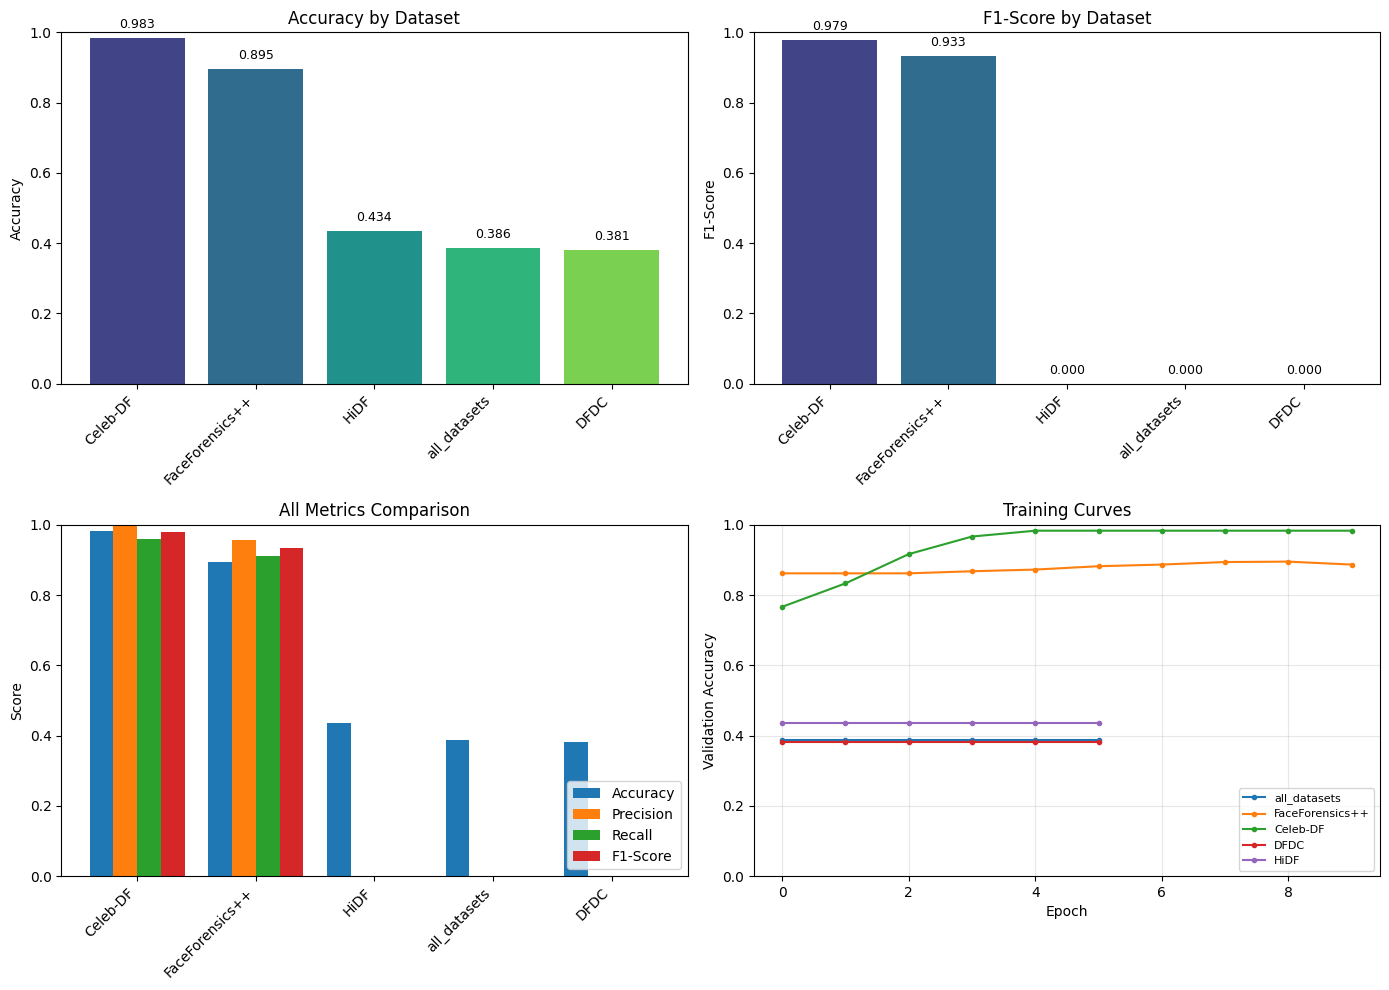


✓ Visualization saved to: E:\MMF Deepfake Detection\results\integrated_training_comparison.png


In [66]:
# ============================================================================
# VISUALIZATION
# ============================================================================

if all_results and len(results_data) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Accuracy comparison
    ax1 = axes[0, 0]
    colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(results_df)))
    bars = ax1.bar(results_df['Dataset'], results_df['Accuracy'], color=colors)
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Accuracy by Dataset')
    ax1.set_ylim(0, 1)
    for bar, acc in zip(bars, results_df['Accuracy']):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                 f'{acc:.3f}', ha='center', va='bottom', fontsize=9)
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Plot 2: F1-Score comparison
    ax2 = axes[0, 1]
    bars = ax2.bar(results_df['Dataset'], results_df['F1-Score'], color=colors)
    ax2.set_ylabel('F1-Score')
    ax2.set_title('F1-Score by Dataset')
    ax2.set_ylim(0, 1)
    for bar, f1 in zip(bars, results_df['F1-Score']):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                 f'{f1:.3f}', ha='center', va='bottom', fontsize=9)
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Plot 3: All metrics comparison
    ax3 = axes[1, 0]
    x = np.arange(len(results_df))
    width = 0.2
    ax3.bar(x - 1.5*width, results_df['Accuracy'], width, label='Accuracy')
    ax3.bar(x - 0.5*width, results_df['Precision'], width, label='Precision')
    ax3.bar(x + 0.5*width, results_df['Recall'], width, label='Recall')
    ax3.bar(x + 1.5*width, results_df['F1-Score'], width, label='F1-Score')
    ax3.set_ylabel('Score')
    ax3.set_title('All Metrics Comparison')
    ax3.set_xticks(x)
    ax3.set_xticklabels(results_df['Dataset'], rotation=45, ha='right')
    ax3.legend(loc='lower right')
    ax3.set_ylim(0, 1)
    
    # Plot 4: Training curves (if available)
    ax4 = axes[1, 1]
    for name, result in all_results.items():
        if result and 'history' in result:
            history = result['history']
            if 'val_accuracy' in history:
                ax4.plot(history['val_accuracy'], label=name, marker='o', markersize=3)
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Validation Accuracy')
    ax4.set_title('Training Curves')
    ax4.legend(loc='lower right', fontsize=8)
    ax4.set_ylim(0, 1)
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(config.RESULTS_DIR / 'integrated_training_comparison.png', dpi=150)
    plt.show()
    
    print(f"\n✓ Visualization saved to: {config.RESULTS_DIR / 'integrated_training_comparison.png'}")

In [67]:
# ============================================================================
# DOMAIN ATTENTION WEIGHTS ANALYSIS
# ============================================================================

print(f"\n{'='*70}")
print("DOMAIN ATTENTION WEIGHTS ANALYSIS")
print(f"{'='*70}")

domain_labels = ['Spatial', 'Frequency', 'Semantic']

if all_results:
    for name, result in all_results.items():
        if result and 'history' in result:
            domain_weights = result['history'].get('domain_weights', [])
            if domain_weights:
                final_weights = domain_weights[-1]
                print(f"\n{name}:")
                for label, weight in zip(domain_labels, final_weights):
                    print(f"  {label}: {weight:.4f} ({weight*100:.1f}%)")


DOMAIN ATTENTION WEIGHTS ANALYSIS

all_datasets:
  Spatial: nan (nan%)
  Frequency: nan (nan%)
  Semantic: nan (nan%)

FaceForensics++:
  Spatial: 0.1858 (18.6%)
  Frequency: 0.0408 (4.1%)
  Semantic: 0.7734 (77.3%)

Celeb-DF:
  Spatial: 0.0003 (0.0%)
  Frequency: 0.0010 (0.1%)
  Semantic: 0.9987 (99.9%)

DFDC:
  Spatial: nan (nan%)
  Frequency: nan (nan%)
  Semantic: nan (nan%)

HiDF:
  Spatial: nan (nan%)
  Frequency: nan (nan%)
  Semantic: nan (nan%)


## Section 12: Cross-Dataset Evaluation

In [68]:
# ============================================================================
# CROSS-DATASET EVALUATION
# ============================================================================

def evaluate_cross_dataset(model, source_dataset, target_dataset):
    """
    Evaluate a model trained on source_dataset on target_dataset.
    Tests generalization across different deepfake datasets.
    """
    # Create target dataset
    target_data = IntegratedMultiDomainDataset(split='val', dataset_filter=target_dataset)
    
    if len(target_data) == 0:
        return None
    
    target_loader = DataLoader(target_data, batch_size=config.BATCH_SIZE, shuffle=False)
    
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for spatial, freq, semantic, labels in target_loader:
            spatial = spatial.to(device)
            freq = freq.to(device)
            semantic = semantic.to(device)
            
            outputs = model(spatial, freq, semantic)
            preds = torch.sigmoid(outputs).cpu().numpy().flatten() >= 0.5
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
    
    return {
        'accuracy': accuracy_score(all_labels, all_preds),
        'f1': f1_score(all_labels, all_preds, zero_division=0)
    }

print(f"\n{'='*70}")
print("CROSS-DATASET GENERALIZATION ANALYSIS")
print(f"{'='*70}")

datasets = ['FaceForensics++', 'Celeb-DF', 'DFDC', 'HiDF']
cross_results = {}

# Evaluate model trained on all datasets on each individual dataset
if 'all_datasets' in all_results and all_results['all_datasets']:
    model_all = all_results['all_datasets']['model']
    
    print("\nModel trained on ALL datasets, evaluated on:")
    for target in datasets:
        result = evaluate_cross_dataset(model_all, 'all', target)
        if result:
            cross_results[f'all->{target}'] = result
            print(f"  {target}: Acc={result['accuracy']:.4f}, F1={result['f1']:.4f}")

# Cross-dataset evaluation for each individual model
print("\nCross-dataset evaluation (train on A, test on B):")
for source in datasets:
    if source in all_results and all_results[source]:
        model = all_results[source]['model']
        for target in datasets:
            if target != source:
                result = evaluate_cross_dataset(model, source, target)
                if result:
                    cross_results[f'{source}->{target}'] = result
                    print(f"  {source} -> {target}: Acc={result['accuracy']:.4f}, F1={result['f1']:.4f}")


CROSS-DATASET GENERALIZATION ANALYSIS

Model trained on ALL datasets, evaluated on:
  Dataset loaded (val): 840 samples (Real: 116, Fake: 724)
  FaceForensics++: Acc=0.1381, F1=0.0000
  Dataset loaded (val): 60 samples (Real: 36, Fake: 24)
  Celeb-DF: Acc=0.6000, F1=0.0000
  Dataset loaded (val): 42 samples (Real: 16, Fake: 26)
  DFDC: Acc=0.3810, F1=0.0000
  Dataset loaded (val): 1227 samples (Real: 533, Fake: 694)
  HiDF: Acc=0.4344, F1=0.0000

Cross-dataset evaluation (train on A, test on B):
  Dataset loaded (val): 60 samples (Real: 36, Fake: 24)
  FaceForensics++ -> Celeb-DF: Acc=0.4833, F1=0.5753
  Dataset loaded (val): 42 samples (Real: 16, Fake: 26)
  FaceForensics++ -> DFDC: Acc=0.8333, F1=0.8444
  Dataset loaded (val): 1227 samples (Real: 533, Fake: 694)
  FaceForensics++ -> HiDF: Acc=0.4996, F1=0.5676
  Dataset loaded (val): 840 samples (Real: 116, Fake: 724)
  Celeb-DF -> FaceForensics++: Acc=0.1381, F1=0.0000
  Dataset loaded (val): 42 samples (Real: 16, Fake: 26)
  Celeb

## Section 13: Final Summary

In [69]:
# ============================================================================
# FINAL SUMMARY
# ============================================================================

print(f"\n{'#'*70}")
print("# INTEGRATED TRAINING COMPLETE - FINAL SUMMARY")
print(f"{'#'*70}")

print(f"\n📊 Configuration:")
print(f"  - Data Percentage: {config.DATA_PERCENTAGE * 100:.1f}%")
print(f"  - Model: Complete Attention Model")
print(f"  - Feature Dimensions: Spatial({config.SPATIAL_DIM}), Freq({config.FREQ_DIM}), Semantic({config.SEMANTIC_DIM})")

print(f"\n📈 Best Results:")
if all_results:
    best_result = max(all_results.items(), key=lambda x: x[1]['metrics']['accuracy'] if x[1] else 0)
    print(f"  - Best Dataset: {best_result[0]}")
    print(f"  - Best Accuracy: {best_result[1]['metrics']['accuracy']:.4f}")
    print(f"  - Best F1-Score: {best_result[1]['metrics']['f1']:.4f}")

print(f"\n📁 Saved Files:")
print(f"  - Metadata: {config.INTEGRATED_METADATA_PATH}")
print(f"  - Results: {config.RESULTS_DIR / 'integrated_training_results.csv'}")
print(f"  - Checkpoints: {config.CHECKPOINTS_DIR}")

print(f"\n{'#'*70}")
print("# TRAINING PIPELINE COMPLETE")
print(f"{'#'*70}")


######################################################################
# INTEGRATED TRAINING COMPLETE - FINAL SUMMARY
######################################################################

📊 Configuration:
  - Data Percentage: 3.0%
  - Model: Complete Attention Model
  - Feature Dimensions: Spatial(2048), Freq(4), Semantic(768)

📈 Best Results:
  - Best Dataset: Celeb-DF
  - Best Accuracy: 0.9833
  - Best F1-Score: 0.9787

📁 Saved Files:
  - Metadata: E:\MMF Deepfake Detection\integrated_metadata.csv
  - Results: E:\MMF Deepfake Detection\results\integrated_training_results.csv
  - Checkpoints: E:\MMF Deepfake Detection\checkpoints

######################################################################
# TRAINING PIPELINE COMPLETE
######################################################################
